# 보스턴 집값 예측하기 - 다항회귀

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append("../../")
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/E04/boston.xlsx")
origin.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1


## #03. 데이터 전처리

### 결측치

>데이터에 결측치가 없으므로 생략

## #04. 탐색적 데이터 분석

### 명목형 처리

더미화가 아닌 단순 category화

>명목형으로 의심되면 일단 value_counts()로 확인

>type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [8]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    int64  
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    int64  
 9   TAX        506 non-null    int64  
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  MEDV       506 non-null    float64
 14  CAT. MEDV  506 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


In [7]:
# origin['CHAS'].value_counts()
# origin['RAD'].value_counts()
origin['CAT. MEDV'].value_counts()

CAT. MEDV
0    422
1     84
Name: count, dtype: int64

In [9]:
origin['CHAS'] = origin['CHAS'].astype('category')
origin['CAT. MEDV'] = origin['CAT. MEDV'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   INDUS      506 non-null    float64 
 3   CHAS       506 non-null    category
 4   NOX        506 non-null    float64 
 5   RM         506 non-null    float64 
 6   AGE        506 non-null    float64 
 7   DIS        506 non-null    float64 
 8   RAD        506 non-null    int64   
 9   TAX        506 non-null    int64   
 10  PTRATIO    506 non-null    float64 
 11  B          506 non-null    float64 
 12  LSTAT      506 non-null    float64 
 13  MEDV       506 non-null    float64 
 14  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(11), int64(2)
memory usage: 52.7 KB


### 기본(기초)통계 확인

In [10]:
origin.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 상자그림

표준화 여부 결정 - boxplot

각 변수의 분포가 너무 상이할 경우 표준화 진행

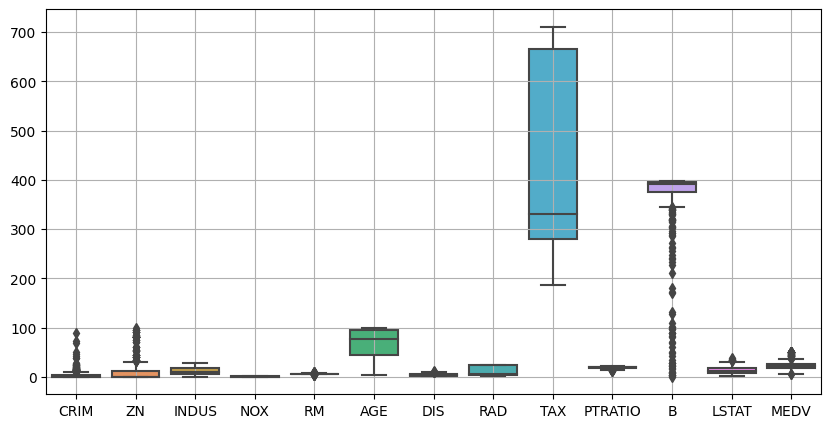

In [12]:
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.grid()
plt.show()
plt.close()

### 제외하기로 한 독립변수 제거

> 상관계수의 절대값이 `0.7`이상인 항목을 순차적으로 제거하여 회귀분석에 사용할 요인을 선정

보통 절댓값 0.2, 0.5, 0.8을 기준 - 데이터 별로 상이함

In [13]:
x = origin.drop(['TAX','DIS', 'NOX','INDUS'], axis=1)
x

,CRIM,ZN,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,0,6.575,65.2,1,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,0,6.421,78.9,2,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,0,7.185,61.1,2,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,0,6.998,45.8,3,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,0,7.147,54.2,3,18.7,396.90,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,0,6.593,69.1,1,21.0,391.99,9.67,22.4,0
502,0.04527,0.0,0,6.120,76.7,1,21.0,396.90,9.08,20.6,0
503,0.06076,0.0,0,6.976,91.0,1,21.0,396.90,5.64,23.9,0
504,0.10959,0.0,0,6.794,89.3,1,21.0,393.45,6.48,22.0,0


### 명목형 변수만 추출

In [15]:
print(list(origin.columns))

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV', 'CAT. MEDV']


In [16]:
categorical_df = x.filter(['CHAS', 'CAT. MEDV'])
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CHAS       506 non-null    category
 1   CAT. MEDV  506 non-null    category
dtypes: category(2)
memory usage: 1.4 KB


### 종속변수만 추출

In [17]:
y = x['MEDV']
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

### 데이터프레임에서 추출한 필드를 제거

In [18]:
x.drop(['CHAS', 'CAT. MEDV', 'MEDV'], axis=1, inplace=True)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   RM       506 non-null    float64
 3   AGE      506 non-null    float64
 4   RAD      506 non-null    int64  
 5   PTRATIO  506 non-null    float64
 6   B        506 non-null    float64
 7   LSTAT    506 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 31.8 KB


## #05. 데이터셋 분할

### 랜덤시드 고정

In [19]:
np.random.seed(777)

### 데이터 표준화

표준화 후 다항식 변환을 진행 - 성능 차이 있음

In [20]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
x_scale

array([[-0.41978194,  0.28482986,  0.41367189, ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236,  0.19427445, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236,  1.28271368, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.98496002, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.72567214, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236, -0.36276709, ...,  1.17646583,
         0.44105193, -0.66905833]])

### 표준화 결과를 다항식으로 변환

numpy의 DF화

In [22]:
type(x_scale)

numpy.ndarray

In [21]:
x_scale_df = DataFrame(x_scale, columns=x.columns)
x_scale_df

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT
0,-0.419782,0.284830,0.413672,-0.120013,-0.982843,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,0.194274,0.367166,-0.867883,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,1.282714,-0.265812,-0.867883,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,1.016303,-0.809889,-0.752922,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,1.228577,-0.511180,-0.752922,0.113032,0.441052,-1.026501
...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.439316,0.018673,-0.982843,1.176466,0.387217,-0.418147
502,-0.415249,-0.487722,-0.234548,0.288933,-0.982843,1.176466,0.441052,-0.500850
503,-0.413447,-0.487722,0.984960,0.797449,-0.982843,1.176466,0.441052,-0.983048
504,-0.407764,-0.487722,0.725672,0.736996,-0.982843,1.176466,0.403225,-0.865302


### 독립변수를 다항식으로 변환

`PolynomialFeatures클래스를 사용`하여 $y = ax + b$ 라는 회귀식을 $y = ax^2 + bx + c$ 형태로 바꾼다.

- degree : 변환할 차수 (기본값=2)
    - 1 : [a,b] = $ax+b$, 2 : [a,b,c] = $ax^2+bx+c$, 3 : [a,b,c,d] = $ax^3+bx^2+cx+d$
- include_bias : True인 경우 0차항(1)도 함께 생성한다. (기본값=True) 
    - 0차항은 유효한 값은 아님.

In [23]:
# degree : 생성할 다항식의 차수
# include_bias : True인 경우 0차항(1)도 함께 생성한다. (기본값=True)
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x_scale_df)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CRIM^2,CRIM ZN,...,RAD^2,RAD PTRATIO,RAD B,RAD LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2
0,-0.419782,0.284830,0.413672,-0.120013,-0.982843,-1.459000,0.441052,-1.075562,0.176217,-0.119566,...,0.965980,1.433968,-0.433485,1.057109,2.128682,-0.643495,1.569246,0.194527,-0.474379,1.156834
1,-0.417339,-0.487722,0.194274,0.367166,-0.867883,-0.303094,0.441052,-0.492439,0.174172,0.203546,...,0.753220,0.263050,-0.382781,0.427380,0.091866,-0.133680,0.149255,0.194527,-0.217191,0.242497
2,-0.417342,-0.487722,1.282714,-0.265812,-0.867883,-0.303094,0.396427,-1.208727,0.174174,0.203547,...,0.753220,0.263050,-0.344052,1.049033,0.091866,-0.120155,0.366358,0.157154,-0.479172,1.461022
3,-0.416750,-0.487722,1.016303,-0.809889,-0.752922,0.113032,0.416163,-1.361517,0.173681,0.203258,...,0.566892,-0.085104,-0.313338,1.025116,0.012776,0.047040,-0.153895,0.173192,-0.566613,1.853728
4,-0.412482,-0.487722,1.228577,-0.511180,-0.752922,0.113032,0.441052,-1.026501,0.170141,0.201177,...,0.566892,-0.085104,-0.332078,0.772876,0.012776,0.049853,-0.116028,0.194527,-0.452740,1.053705


### 분리해 놓은 명목형 데이터와 결합

In [24]:
x_df = merge(x2, categorical_df, left_index=True, right_index=True)
x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CRIM           506 non-null    float64 
 1   ZN             506 non-null    float64 
 2   RM             506 non-null    float64 
 3   AGE            506 non-null    float64 
 4   RAD            506 non-null    float64 
 5   PTRATIO        506 non-null    float64 
 6   B              506 non-null    float64 
 7   LSTAT          506 non-null    float64 
 8   CRIM^2         506 non-null    float64 
 9   CRIM ZN        506 non-null    float64 
 10  CRIM RM        506 non-null    float64 
 11  CRIM AGE       506 non-null    float64 
 12  CRIM RAD       506 non-null    float64 
 13  CRIM PTRATIO   506 non-null    float64 
 14  CRIM B         506 non-null    float64 
 15  CRIM LSTAT     506 non-null    float64 
 16  ZN^2           506 non-null    float64 
 17  ZN RM          506 non-null    floa

### 훈련 데이터와 검증 데이터로 분할

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((354, 46), (152, 46), (354,), (152,))

## #06. 모델 개발

### 모델 정의

- input_shape은 독립변수 수
- Dense 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [26]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train.columns), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3008      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5121 (20.00 KB)
Trainable params: 5121 (20.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [27]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
12/12 [==============================] - 2s 26ms/step - loss: 502.6375 - mae: 20.6321 - val_loss: 451.0467 - val_mae: 19.0598 - lr: 0.0010
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 428.3900 - mae: 18.8268 - val_loss: 377.4883 - val_mae: 17.2626 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 12ms/step - loss: 352.1726 - mae: 16.6879 - val_loss: 304.7949 - val_mae: 15.2523 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 287.7693 - mae: 14.7012 - val_loss: 243.8668 - val_mae: 13.5719 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 6ms/step - loss: 235.0095 - mae: 13.4408 - val_loss: 198.7830 - val_mae: 12.1880 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 194.3371 - mae: 12.1679 - val_loss: 156.3460 - val_mae: 10.6003 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 150.9099 - mae: 10.5783 -

## #07. 학습 결과 평가

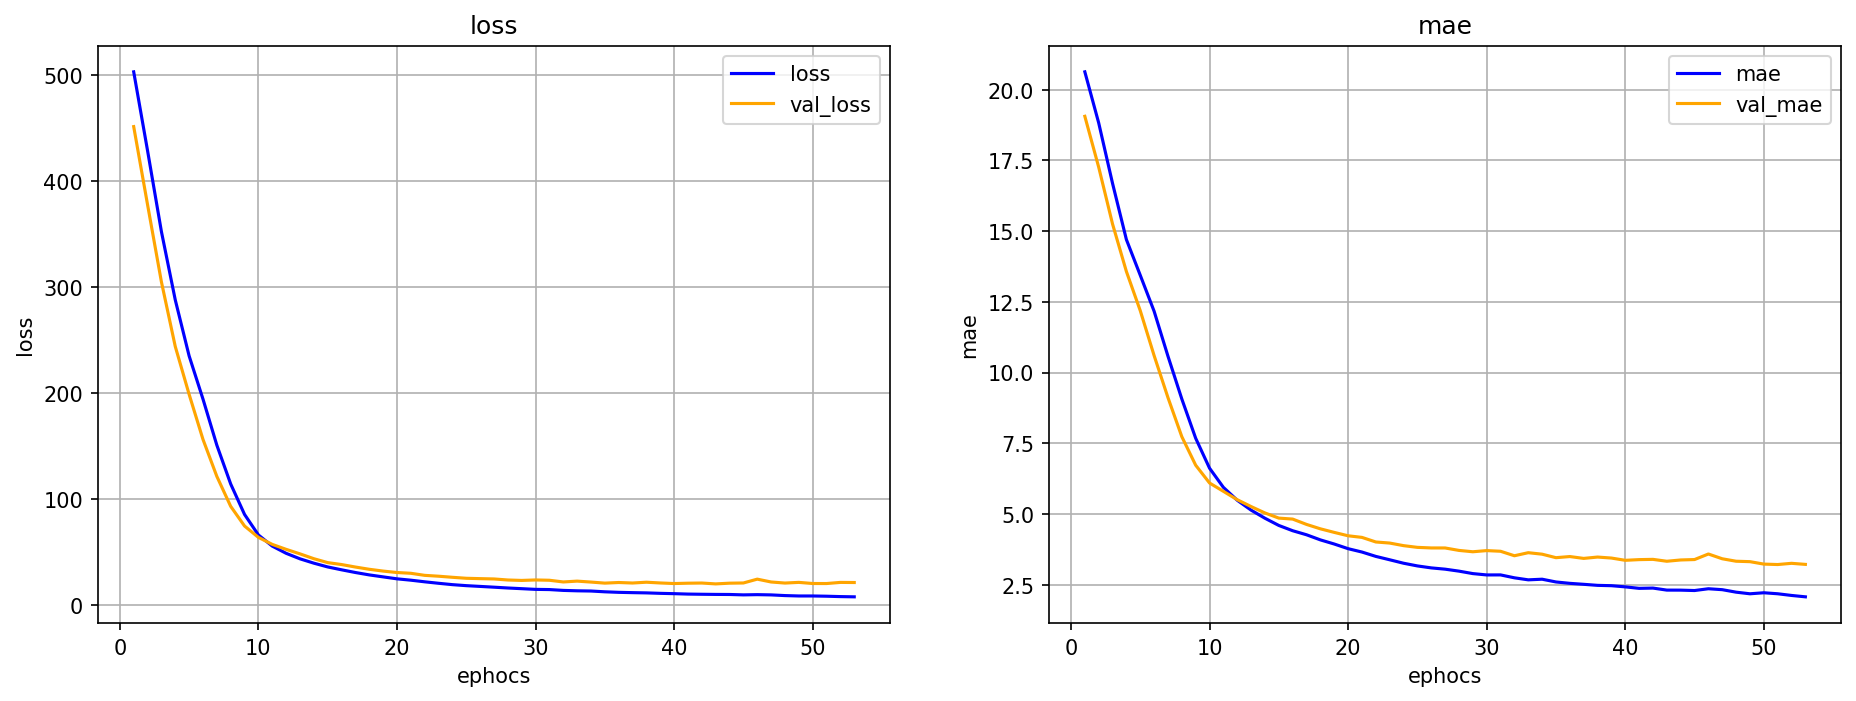

12/12 [==============================] - 0s 2ms/step - loss: 7.8149 - mae: 2.0523
최종 훈련 손실률: 7.814915, 최종 훈련 절대오차: 2.052320
5/5 [==============================] - 0s 3ms/step - loss: 21.4917 - mae: 3.2177
최종 검증 손실률: 21.491737, 최종 검증 절대오차: 3.217738


In [28]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [29]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

5/5 [==============================] - 0s 2ms/step


### 결과 데이터 셋 구성

#### 학습 데이터

In [30]:
train_df = DataFrame(x_train, columns=x_train.columns)
train_df['관측치'] = y_train.values
train_df['예측치'] = train_pred.flatten()

train_df['훈련오차'] = train_df['관측치']-train_df['예측치']

train_df.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CRIM^2,CRIM ZN,...,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS,CAT. MEDV,관측치,예측치,훈련오차
372,0.541569,-0.487722,-0.583589,0.747665,1.661245,0.806576,-0.096421,-0.528885,0.293297,-0.264135,...,-0.077771,-0.426585,0.009297,0.050996,0.279719,1,1,50.0,38.188187,11.811813
18,-0.327103,-0.487722,-1.180521,-1.137046,-0.637962,1.176466,-0.742112,-0.134996,0.106997,0.159536,...,-0.873069,-0.158818,0.550730,0.100182,0.018224,0,0,20.2,17.112495,3.087505
185,-0.413480,-0.487722,-0.187534,0.008005,-0.752922,-0.303094,0.333711,0.069658,0.170966,0.201664,...,-0.101146,-0.021113,0.111363,0.023245,0.004852,0,0,29.6,22.940153,6.659847
57,-0.418851,3.804234,0.757015,-0.998360,-0.523001,-1.551473,0.397194,-1.219941,0.175436,-1.593407,...,-0.616236,1.892706,0.157763,-0.484554,1.488257,0,1,31.6,32.196957,-0.596957
261,-0.358360,0.370669,1.759974,0.740552,-0.523001,-2.522434,0.347526,-0.755966,0.128422,-0.132833,...,-0.876611,1.906875,0.120774,-0.262718,0.571485,0,1,43.1,40.105190,2.994810


#### 검증 데이터

In [31]:
test_df = DataFrame(x_test, columns=x_train.columns)
test_df['관측치'] = y_test.values
test_df['예측치'] = test_pred.flatten()

test_df['훈련오차'] = test_df['관측치']-test_df['예측치']

test_df.head()

,CRIM,ZN,RM,AGE,RAD,PTRATIO,B,LSTAT,CRIM^2,CRIM ZN,...,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2,CHAS,CAT. MEDV,관측치,예측치,훈련오차
207,-0.391193,-0.487722,-0.714658,0.146691,-0.637962,0.066796,0.359148,0.757911,0.153032,0.190793,...,0.023990,0.050625,0.128987,0.272202,0.574429,0,0,22.5,18.858795,3.641205
425,1.425197,-0.487722,-0.553671,0.953916,1.661245,0.806576,-3.826496,1.645211,2.031186,-0.695100,...,-3.086359,1.326987,14.642069,-6.295392,2.706719,0,0,8.3,11.897341,-3.597341
408,0.441097,-0.487722,-0.951151,1.042817,1.661245,0.806576,-0.460876,1.926960,0.194567,-0.215133,...,-0.371732,1.554239,0.212407,-0.888090,3.713175,0,0,17.2,9.643000,7.557000
63,-0.405796,0.585267,0.680083,-0.895234,-0.178120,0.575395,0.426579,-0.441977,0.164671,-0.237499,...,0.245451,-0.254311,0.181970,-0.188538,0.195343,0,0,25.0,21.100786,3.899214
290,-0.416442,2.945843,0.821124,-1.446423,-0.637962,0.344213,0.441052,-1.306849,0.173424,-1.226773,...,0.151816,-0.449835,0.194527,-0.576388,1.707854,0,0,28.5,28.251953,0.248047


### 실제 결과값과 머신러닝에 의한 예측값 비교

In [33]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

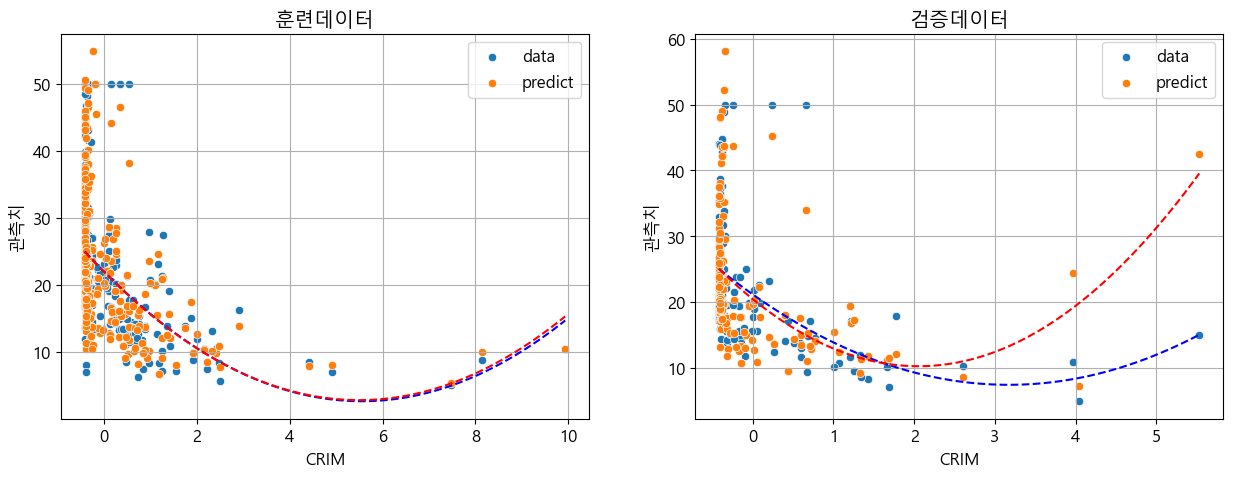

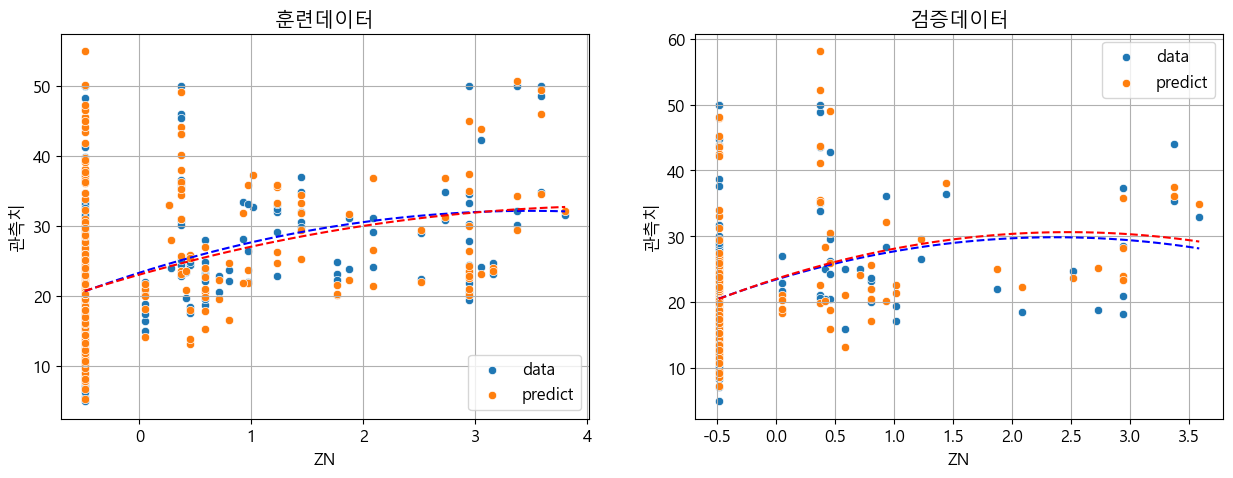

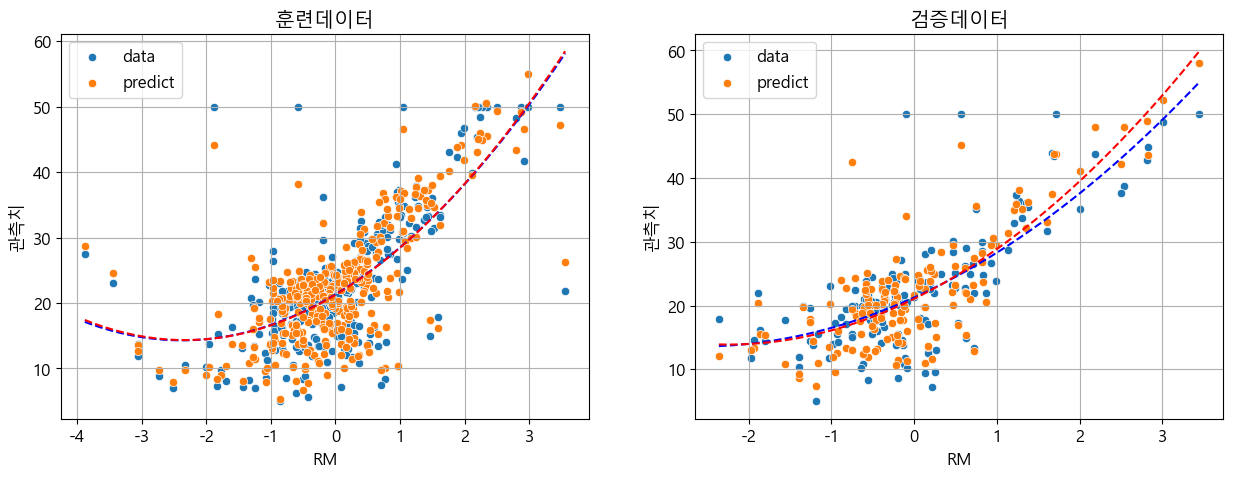

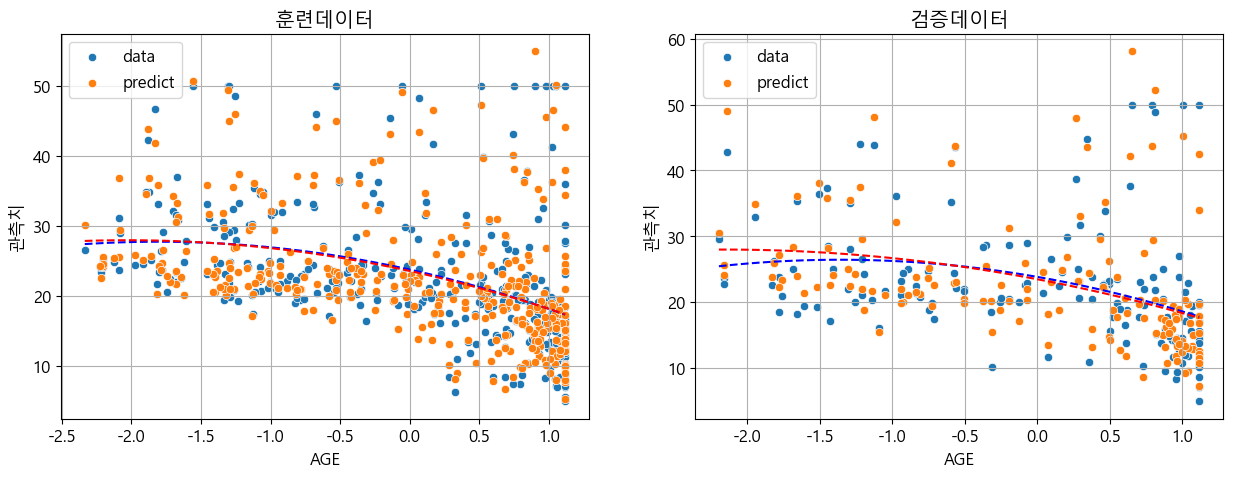

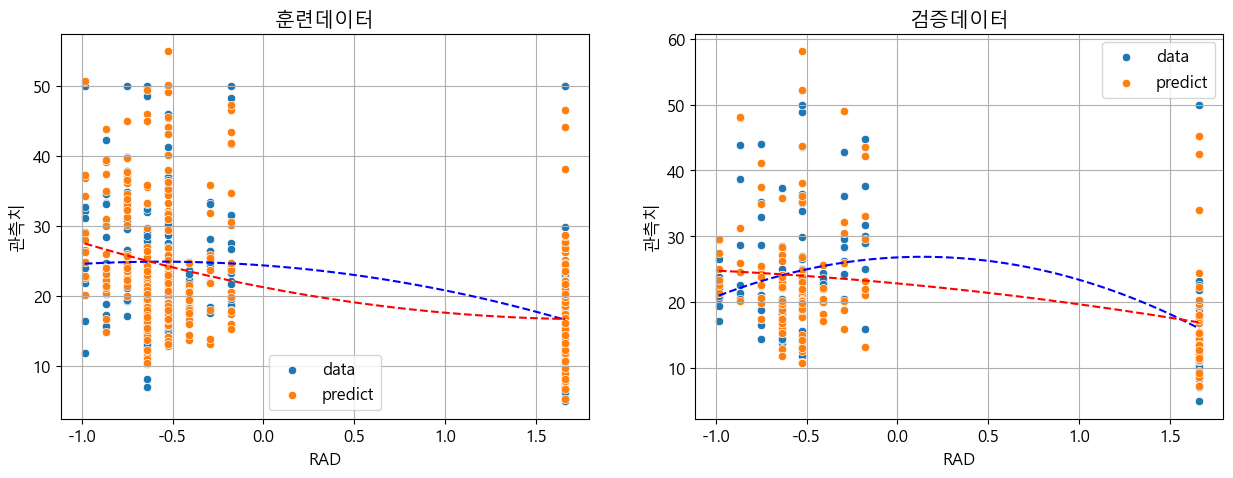

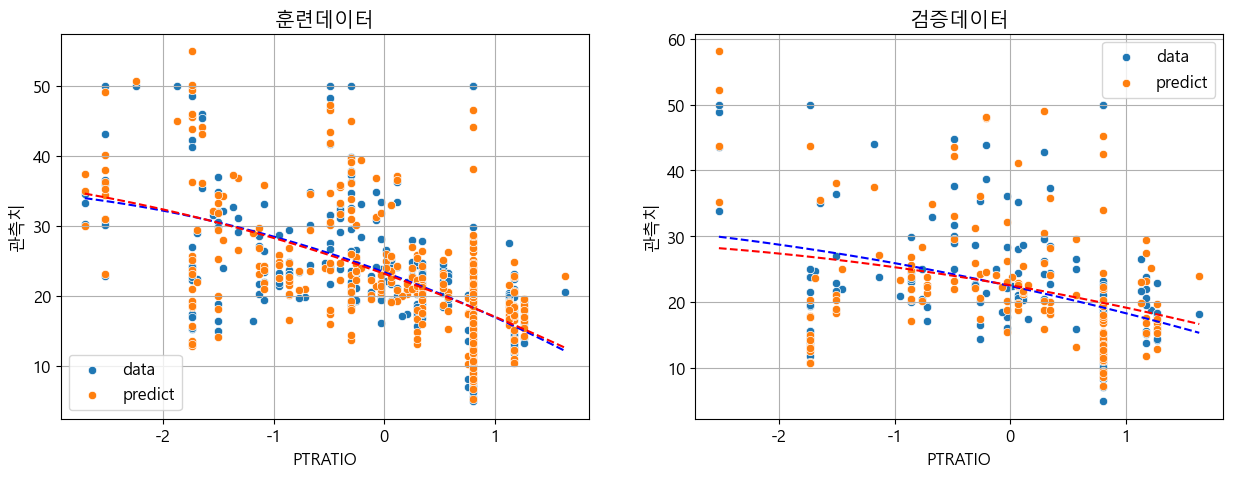

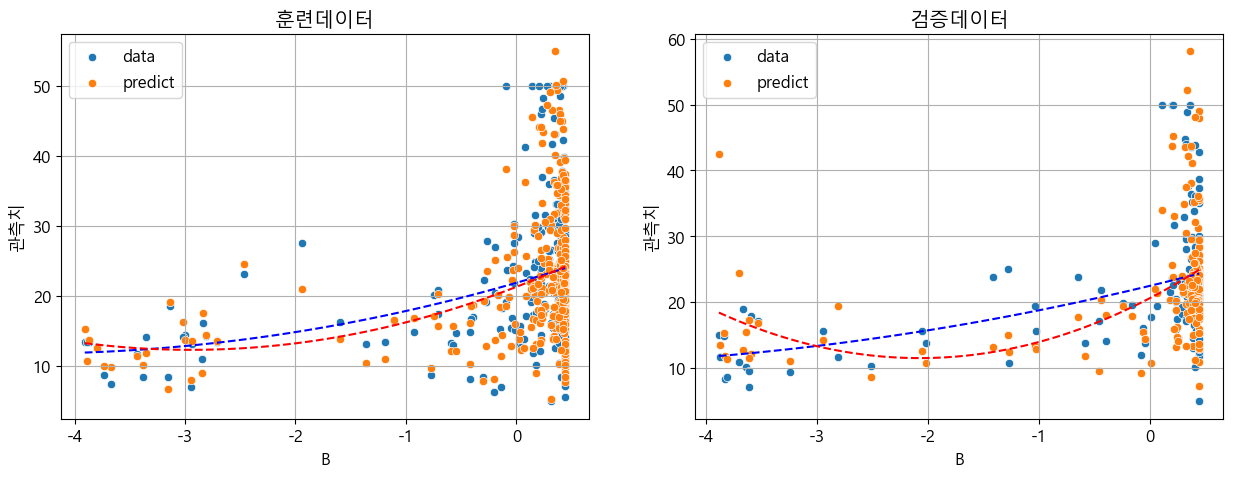

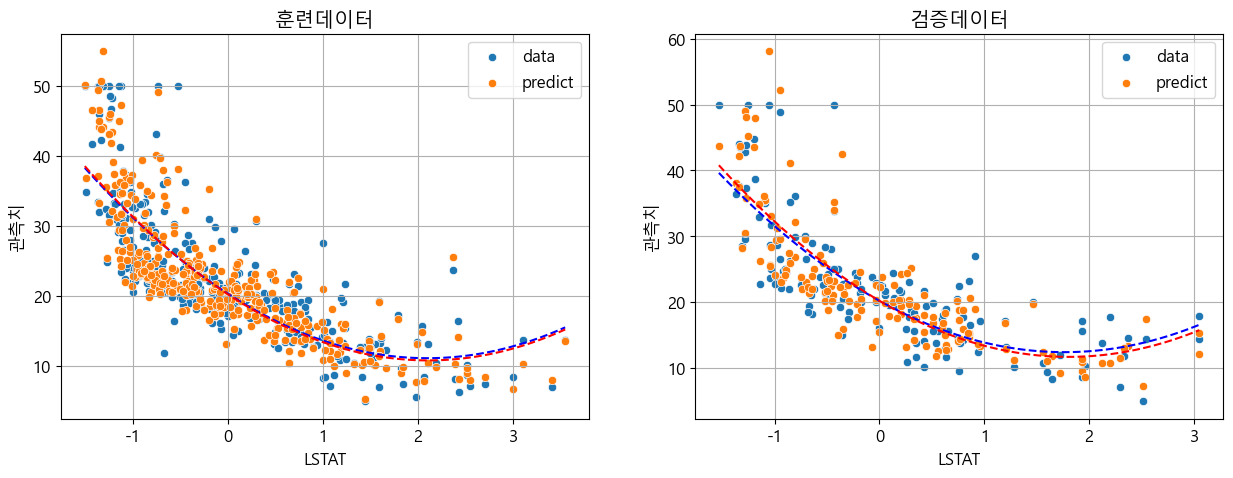

In [34]:
for key in ['CRIM','ZN','RM','AGE','RAD','PTRATIO','B','LSTAT']:
    helper.regplot(train_df[key], train_df['관측치'], train_df['예측치'], "훈련데이터",
                   test_df[key], test_df['관측치'], test_df['예측치'], "검증데이터",
                   figsize=(15, 5))